In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
df = pd.read_excel (r'gujrati_modelDataset.xlsx', sheet_name='Sheet1')
print(df.head())

   sent_index        word    tag
0           0      ભારતીય  B-LOC
1           0     ગણરાજ્ય      O
2           0           એ      O
3           0        અનેક      O
4           0  સાંસ્કૃતિક      O


In [3]:
len(df)

48031

In [4]:
df[df['word'].str.match(r'[A-Za-z0-9]\w+') == True]

,sent_index,word,tag
231,17,Error404,O
587,46,Punjabi,O
742,60,Error404,O
1002,83,Error404,O
1543,123,Error404,O
...,...,...,...
47735,3415,The,O
47745,3416,Error404,O
47790,3421,Eared,O
47791,3421,Grebe,O


In [5]:
df.drop(df[df['word'].str.match(r'[A-Za-z0-9]\w+') == True].index, inplace = True)

In [6]:
len(df)

47598

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(df)

In [9]:
sentences = getter.sentences

In [10]:
print(sentences[10])

[('બદ્રીનાથ', 'B-LOC'), ('ભારત', 'B-LOC'), ('દેશની', 'O'), ('ઉત્તર', 'B-LOC'), ('દિશામાં', 'O'), ('આવેલા', 'O'), ('હિમાલય', 'B-LOC'), ('પર્વતમાળામાં', 'I-LOC'), ('આવેલા', 'O'), ('ઉત્તરાંચલ', 'O'), ('રાજ્યમાં', 'I-LOC'), ('આવેલું', 'O'), ('હિંદુ', 'B-ORG'), ('ધર્મના', 'O'), ('લોકોનું', 'O'), ('મહત્વનું', 'O'), ('તીર્થસ્થળ', 'O'), ('છે', 'O')]


In [11]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 55


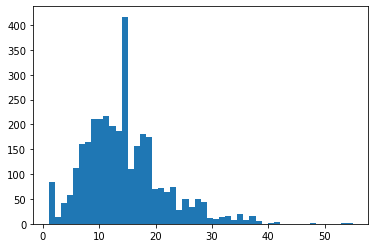

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
words = list(set(df["word"].values))
words.append("end_padding")
n_words = len(words)
n_words

6417

In [14]:
tags = list(set(df["tag"].values))
n_tags = len(tags)
n_tags

7

In [15]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
print(type(word2idx))

<class 'dict'>


In [17]:
dict_items = word2idx.items()
first_5 = list(dict_items)[:5]
print(first_5)

[('અરણ્ય', 0), ('કાકા', 1), ('અપનાવાયો', 2), ('સ્કોટલેન્ડમાં', 3), ('મેડીકલ', 4)]


In [18]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [19]:
X = pad_sequences(maxlen=82, sequences=X, padding="post",value=n_words - 1)

In [20]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=82, sequences=y, padding="post", value=tag2idx["O"])

In [21]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [24]:
input = Input(shape=(82,))
model = Embedding(input_dim=n_words, output_dim=82, input_length=82)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [25]:
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10, validation_split=0.2, verbose=1)

C:\Users\rosha\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2115 samples, validate on 529 samples
Epoch 1/10
2115/2115 [==============================] - 10s 5ms/step - loss: 0.4124 - accuracy: 0.9339 - val_loss: 0.1698 - val_accuracy: 0.9466
Epoch 2/10
2115/2115 [==============================] - 9s 4ms/step - loss: 0.1536 - accuracy: 0.9484 - val_loss: 0.1415 - val_accuracy: 0.9500
Epoch 3/10
2115/2115 [==============================] - 10s 5ms/step - loss: 0.1135 - accuracy: 0.9626 - val_loss: 0.0929 - val_accuracy: 0.9748
Epoch 4/10
2115/2115 [==============================] - 9s 4ms/step - loss: 0.0704 - accuracy: 0.9816 - val_loss: 0.0597 - val_accuracy: 0.9836
Epoch 5/10
2115/2115 [==============================] - 10s 5ms/step - loss: 0.0449 - accuracy: 0.9871 - val_loss: 0.0431 - val_accuracy: 0.9864
Epoch 6/10
2115/2115 [==============================] - 9s 4ms/step - loss: 0.0317 - accuracy: 0.9894 - val_loss: 0.0343 - val_accuracy: 0.9892
Epoch 7/10
2115/2115 [==============================] - 9s 4ms/step - loss: 0.0234 - a

In [27]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
રંગારેડ્ડી    : B-LOC
જિલ્લો        : I-LOC
ભારત          : B-LOC
દેશના         : O
તેલંગાણા      : B-LOC
રાજ્યનો       : O
મહત્વનો       : O
જિલ્લો        : I-LOC
છે            : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   : O
end_padding   :

In [28]:
pred = []
for i in range(len(y_test)):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    pred.append(p)

In [29]:
pred_temp = [x[0] for x in pred]

In [30]:
y_temp = []

In [31]:
for i in range(len(y_test)):
    y_temp.append(np.array([np.where(y_test[i][j]==1)[0][0] for j in range(len(y_test[i]))]))

In [32]:
actual = y_temp[0]
for i in range(1, len(y_temp)):
    actual = np.concatenate((actual, y_temp[i]), axis=None)

In [33]:
predicted = pred_temp[0]
for i in range(1, len(pred_temp)):
    predicted = np.concatenate((predicted, pred_temp[i]), axis=None)


Confusion Matrix and Classification Report

 AxesSubplot(0.125,0.125;0.62x0.755)

               precision    recall  f1-score   support

       B-PER       0.82      0.75      0.78       138
       B-LOC       0.97      0.94      0.95      1304
       I-LOC       1.00      0.98      0.99       895
       B-ORG       0.98      0.89      0.94       217
       I-ORG       0.92      0.88      0.90       139
           O       1.00      1.00      1.00     51450
       I-PER       0.94      0.89      0.91       141

    accuracy                           1.00     54284
   macro avg       0.95      0.90      0.93     54284
weighted avg       1.00      1.00      1.00     54284



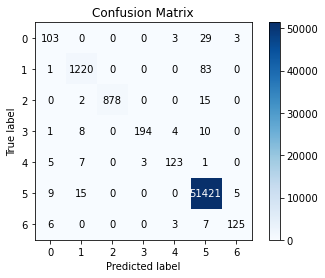

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
print('\nConfusion Matrix and Classification Report')
print('\n', skplt.metrics.plot_confusion_matrix(actual, predicted))
print('\n', classification_report(actual, predicted, target_names=tags))